In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#reading the dataset
df = pd.read_csv('..\\dataset\\train-balanced-sarcasm.csv')
df.shape

(1010826, 10)

In [3]:
#Storing the file in parquet format as it is faster to read and write
df.to_parquet('..\\dataset\\train-balanced-sarcasm.parquet')

In [4]:
df = pd.read_parquet('..\\dataset\\train-balanced-sarcasm.parquet')
df.shape

(1010826, 10)

In [5]:
df.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Observations in Train Data:</u></b><br>
 
* <i> There are total of <b><u>10</u></b> columns and <b><u>1,010,826</u></b> rows in <b><u>train</u></b> data.</i><br>
* <i> There are only 53 missing values that too from comment column</i><br>
* <i> This is a binary classification problem</i><br>
</div>

** Data has balanced and imbalanced (i.e true distribution) versions. (True ratio is about 1:100).<br>
** The provided dataset is a balance version

**Column Description :**
* `label` - Contains class label 0 - Non Sarcastic | 1 - Sarcastic <br>
Rest all of the column are self explanatory

In [8]:
df.columns.to_list()

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [7]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


<AxesSubplot:title={'center':'Histogram of label column'}, xlabel='Label', ylabel='Frequency'>

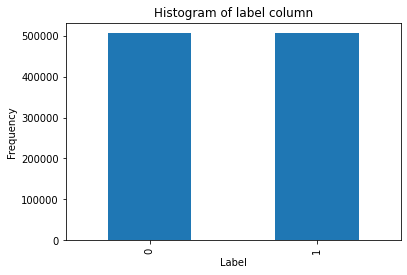

In [10]:
#plot histogram on label column 
plt.title('Histogram of label column')
plt.xlabel('Label')
plt.ylabel('Frequency')
df['label'].value_counts().plot(kind='bar')

In [9]:
df['subreddit'].value_counts()

AskReddit                65677
politics                 39496
worldnews                26377
leagueoflegends          21037
pcmasterrace             18988
                         ...  
LabiaGW                      1
Expected                     1
AnimalsStoppingFights        1
panderingfromtheright        1
Pandemic                     1
Name: subreddit, Length: 14878, dtype: int64

* There are 14,878 unique subreddit present in the dataset <br>
* We can see that most of the comments are from 'AskReddit' channel i.e 6.5%

In [14]:
len(df['author'].unique())

256561

Only 250K+ unique authors are present in the dataset, which means the dataset have multiple comments from the same authors

In [20]:
#Checking if any comments is duplicate 
comment_counts = df['comment'].value_counts().to_dict()
#get top 10 most frequent comments
comment_counts = sorted(comment_counts.items(), key=lambda x: x[1], reverse=True)[:10]
comment_counts

[('You forgot the', 1451),
 ('Yes', 470),
 ('you forgot the', 456),
 ('Yes.', 456),
 ('Thanks!', 396),
 ('You dropped this:', 343),
 ('No.', 342),
 ('You forgot your', 329),
 ('You forgot', 283),
 ('No', 277)]

* Here we can see that many came comments are repeated multiple, So at the time of data preprocessing we can drop these repeated comments, so our model doesnt get overfit

<AxesSubplot:ylabel='Density'>

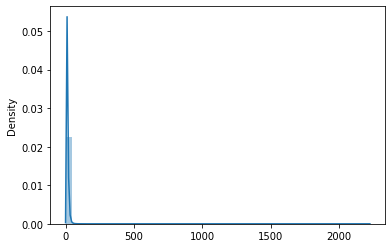

In [43]:
#no of words in each comment
comment_length = [len(x) for x in df['comment'].str.split(' ') if x != None]
sns.distplot(comment_length)

<AxesSubplot:ylabel='Density'>

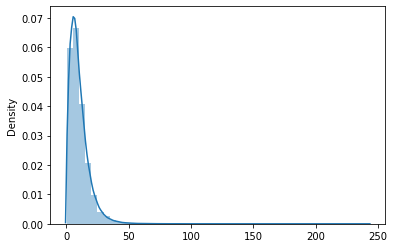

In [44]:
#Focusing between 0 - 250 words
comment_length = [len(x) for x in df['comment'].str.split(' ') if x != None and len(x) < 250]
sns.distplot(comment_length)

* Here we can see that most of the comments have less than 50 words in it 

In [45]:
#Percentile on comment length
for i in range(0,110,10):
    print(i, np.percentile(comment_length, i))

0 1.0
10 3.0
20 4.0
30 6.0
40 7.0
50 9.0
60 10.0
70 12.0
80 15.0
90 20.0
100 242.0


In [46]:
#Percentile on comment length
for i in range(90,101):
    print(i, np.percentile(comment_length, i))

90 20.0
91 21.0
92 22.0
93 23.0
94 24.0
95 25.0
96 27.0
97 29.0
98 32.0
99 38.0
100 242.0


* So at the preprocessing step we could pad all of our sentence to 40 words, as 99% of comments have less than 38 words in it
* This would result in faster training and also save us excess GPU and RAM usage

In [27]:
df['score'].min() , df['score'].max()

(-507, 9070)

* Over here score columns varies from -507 to 9070. Usually the comments which are insensitive or irrelevant gets down voted in the reddit, So score could be the imp factor over here

<AxesSubplot:xlabel='ups', ylabel='Density'>

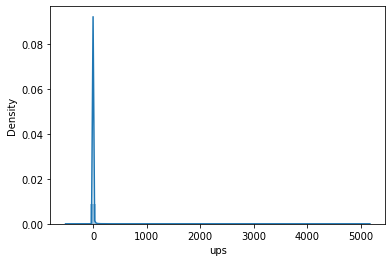

In [30]:
#plot sns distribuition on ups column
sns.distplot(df['ups'])

In [47]:
#percentile on ups column
for i in range(0,110,10):
    print(i, np.percentile(df['ups'], i))

0 -507.0
10 -1.0
20 -1.0
30 1.0
40 1.0
50 1.0
60 2.0
70 3.0
80 5.0
90 10.0
100 5163.0


* Here the ups columns consist some negative sample, which could be consider as wrong point as ups columns should only consist positive number, so we could set those points as NaN at preprocessing step

<AxesSubplot:xlabel='downs', ylabel='Density'>

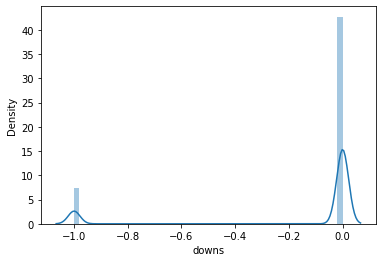

In [31]:
#plot sns distribuition on downs column
sns.distplot(df['downs'])

In [48]:
#percentile on downs column
for i in range(0,110,10):
    print(i, np.percentile(df['downs'], i))

0 -1.0
10 -1.0
20 0.0
30 0.0
40 0.0
50 0.0
60 0.0
70 0.0
80 0.0
90 0.0
100 0.0


* There are no outliers present in the downs columns, as all the points are less than or equal to 0

<AxesSubplot:ylabel='Density'>

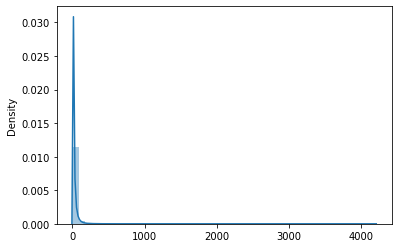

In [50]:
#no of words in each parent_comment
comment_length = [len(x) for x in df['parent_comment'].str.split(' ') if x != None]
sns.distplot(comment_length)

<AxesSubplot:ylabel='Density'>

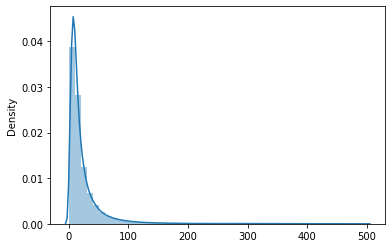

In [51]:
#Focusing between 0 - 500 words
comment_length = [len(x) for x in df['parent_comment'].str.split(' ') if x != None and len(x) < 500]
sns.distplot(comment_length)

In [52]:
#Percentile on parent_comment length
for i in range(0,110,10):
    print(i, np.percentile(comment_length, i))

0 1.0
10 4.0
20 7.0
30 9.0
40 11.0
50 14.0
60 17.0
70 23.0
80 32.0
90 51.0
100 499.0


* parent_comment also follow the similar pattern as compare to comment columns, so we could also pad the parent column to certain threshold to reduce the computational resource

### Problem Statement - 
We want an ML model to predict whether the given comment is sarcastic or not


### What is our Ideal Outcome?
Our ideal outcome is to classify the comment whether it is sarcastic or not, and later on, we could use and expand this model to another problem statement such as classifying spam comments/ bots comment, classifying political / hate speech / controversial comments/racists comment, etc. <br>
The ideal outcome is to make the comment section cleaner and more useful and entertaining to the user.


### How will you know if your system has succeeded or failed?
A success metric is the user engagement in the comment section. If more people are commenting on the post, then it means more people are engaging on the site i.e visitor time of the site increases. Failure means the reduction of comments on posts after serving the model ex - due to incorrect classification of the comment.

### How we can use this model in production setting?
We’ll predict the comment when the user posts it. This outcome will help us to determine where to rank this comment. In Reddit, the comments are usually sorted to user preference usually by time or by most votes, if nothing is selected then it is sorted by votes. So let's consider a scenario where multiple user posts comments and none of the comments have any upvotes. So over here we can rank them according to Most sarcastic comments to least sarcastic comments. Note - This approach might only apply to certain subreddit, where humor or jokes is the theme of the subreddit. We could also identify the subreddit genre, by building a simple NLP model which reads the subreddit info section and identity whether this subreddit is about jokes/ memes/ etc or not